In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.139:41347,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
upwelling_cafe_700=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-700,method='nearest') #
upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S

In [22]:
#Try get densty out along a single face.
cd1=cafe_potential_density.chunk('auto').interp(lon=cafe_x_tx.lon_x).drop('lon')

array([  -1,   -2,   -3,   -4,   -5,   -6,   -7,   -8,   -9,  -10,  -11,
        -12,  -13,  -14,  -15,  -16,  -17,  -18,  -19,  -20,  -21,  -22,
        -23,  -24,  -25,  -26,  -27,  -28,  -29,  -30,  -31,  -32,  -33,
        -34,  -35,  -36,  -37,  -38,  -39,  -40,  -41,  -42,  -43,  -44,
        -45,  -46,  -47,  -48,  -49,  -50,  -51,  -52,  -53,  -54,  -55,
        -56,  -57,  -58,  -59,  -60,  -61,  -62,  -63,  -64,  -65,  -66,
        -67,  -68,  -69,  -70,  -71,  -72,  -73,  -74,  -75,  -76,  -77,
        -78,  -79,  -80,  -81,  -82,  -83,  -84,  -85,  -86,  -87,  -88,
        -89,  -90,  -91,  -92,  -93,  -94,  -95,  -96,  -97,  -98,  -99,
       -100, -101, -102, -103, -104, -105, -106, -107, -108, -109, -110,
       -111, -112, -113, -114, -115, -116, -117, -118, -119, -120, -121,
       -122, -123, -124, -125, -126, -127, -128, -129, -130, -131, -132,
       -133, -134, -135, -136, -137, -138, -139, -140, -141, -142, -143,
       -144, -145, -146, -147, -148, -149, -150, -1

In [ ]:
#cd1.interp(st_ocean=np.arange(-1,-969,-1))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 968, lat: 140, lon_x: 171)>
dask.array<transpose, shape=(731, 968, 140, 171), dtype=float64, chunksize=(43, 968, 70, 171), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * st_ocean  (st_ocean) int64 -1 -2 -3 -4 -5 -6 ... -964 -965 -966 -967 -968

In [11]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [8]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [9]:
# mmol/s
#10^9 kg/s

In [10]:
# Compare Area vs Transport??

In [11]:
#area_m2/1e6

In [28]:
cafe_x_tx#=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

### Check some of the vars to make sure they look ok

In [12]:
cafe_x_tx

#mmol/m3 * 1e9 KG/S (/1e6?)

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [13]:
adic_cafe

<xarray.DataArray 'adic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [14]:
dic_cafe

<xarray.DataArray 'dic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [15]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

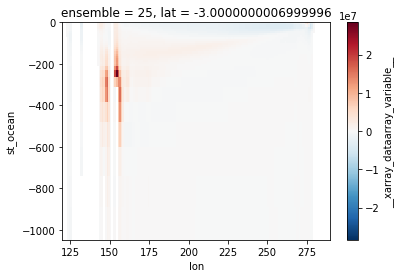

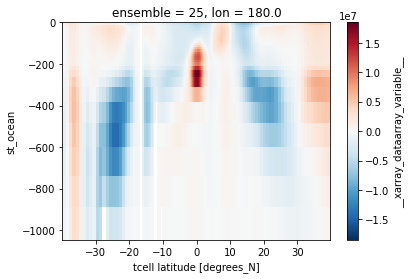

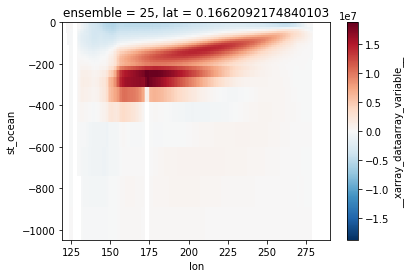

In [16]:

anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK

#chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
plt.show()
anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
plt.show()
anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

In [17]:

dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc').tracer
anth_dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc').tracer

dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc').tracer
anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc').tracer
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/upwelling_density.nc').tracer
anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anthupwelling_density.nc').tracer

#dic_w_tx_dens.sel(density=1025,method='nearest').mean(dim='time').plot()


In [18]:
#cafe_y_tx_gm.sel(time='2010-01-01',lat_x=3,lon=180,method='nearest').plot()

In [23]:
d=dic_u_tx_dens.chunk('auto')
ds_masked = d.where(d!=0)
#d[ds_masked]=np.nan

In [24]:
ds_masked

<xarray.DataArray 'tracer' (time: 731, lat: 140, lon: 170, density: 139)>
dask.array<where, shape=(731, 140, 170, 139), dtype=float32, chunksize=(43, 70, 76, 76), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * density   (density) float64 1.018e+03 1.018e+03 ... 1.032e+03 1.032e+03

In [20]:
d

<xarray.DataArray 'tracer' (time: 731, lat: 140, lon: 170, density: 139)>
dask.array<xarray-<this-array>, shape=(731, 140, 170, 139), dtype=float32, chunksize=(43, 70, 76, 76), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * density   (density) float64 1.018e+03 1.018e+03 ... 1.032e+03 1.032e+03

(1030.0, 1020.0)

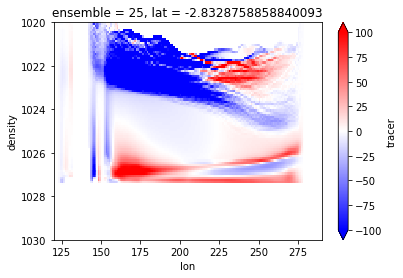

In [27]:
dat=dic_u_tx_dens.chunk('auto')
dat.where(dat!=0).sel(lat=-3,method='nearest').mean(dim='time').T.plot(vmin=-100,vmax=100,cmap='bwr')
ax = plt.gca()
plt.ylim([1030,1020])

In [21]:
#anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

## Calculate ENSO Months

In [22]:
#anth_dic_u_tx

In [23]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [24]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc_sel_between_density_layers(ds,cutoff=0,mean=True,printer=True,mmols_to_pgYr_convert=True):
    density_layers=[1020,1023,1025.5,1026.3,1030]
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18
    
    #pd.DataFrame(
    layer_results=[]
    for i in range(len(density_layers)-1):
        dens0=density_layers[i]
        dens1=density_layers[i+1]
        print(dens0)

        ds_denslayer=ds.sel(density=slice(dens0,dens1))
        pos=ds_denslayer.where(ds>cutoff)
        neg=ds_denslayer.where(ds<-cutoff)

        if mean==True:
            res=[pos.mean().values,neg.mean().values]
        elif mean==False:
            res=[pos.sum().values,neg.sum().values]
        if printer==True:
            print(np.array(res))
            print(ds1.where(ds1>0).mean().values)
            
        layer_results.append((np.array(res).tolist()))
        
    return layer_results

In [25]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(ds,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True):
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(np.array(res))
        print(ds1.where(ds1>0).mean().values)
    return np.array(res)

In [26]:
dic_transport_through_box=pd.DataFrame()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [27]:
#densitylevs=[1022,1024.5,1026.7]#6.9]
#(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

In [33]:
densitylevs=[1023,1024.5,1026.3,1026.7,1027,1027.5]


posneg_calc_method=xarray_posneg_calc
plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx_dens,dic_v_tx_dens]
    
    #[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-1000)),
                    #dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-1000))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):


        for lat in [3,-3]:
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3S'

            plt.figure(figsize=(20,5))
            plt.subplot(141)
            if ((i==0)|(i==2)): 
                levs=None#np.arange(-4e6,4.5e6,5e5)
            elif i==1: 
                levs=np.arange(-20,20,1)#None#np.arange(-1e8,1.1e8,5e6)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            plt.subplot(141)        
            ax=adic_tx_n.sel(time=neutral_events).mean(dim='time').T.plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=neutral_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_neutral=posneg_calc_method(adic_tx_n.sel(time=neutral_events).mean(dim='time'))
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1]) # Reverse Yax.
            
            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.ylabel('Density kg/m3')
            
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            plt.subplot(142)
            adic_tx_n.sel(time=ep_events).mean(dim='time').T.plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=ep_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_ep=posneg_calc_method(adic_tx_n.sel(time=ep_events).mean(dim='time'))
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.ylabel('Density kg/m3')
            
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1]) # Reverse Yax.

            plt.subplot(143)
            adic_tx_n.sel(time=cp_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_n.sel(time=cp_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_cp=posneg_calc_method(adic_tx_n.sel(time=cp_events).mean(dim='time'))
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            plt.title(f'CP {N_S_names[i]} at {direct}')

            plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.ylabel('Density  kg/m3')
            
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1]) # Reverse Yax.
            
            plt.subplot(144)
            adic_tx_n.sel(time=nina_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_n.sel(time=nina_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_nina=posneg_calc_method(adic_tx_n.sel(time=nina_events).mean(dim='time'))
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.ylabel('Density  kg/m3')
            
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1]) # Reverse Yax.
            
            plt.tight_layout()
        
            plt.show()
           
            #temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            #dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
dic_transport_through_box   

KeyboardInterrupt: 

In [29]:
asum_neutral                                  

array([ 3.8670292e-05, -2.7214275e-05], dtype=float32)

In [ ]:
anth_dic_u_tx_dens.mean(dim='time').sel(lat=-3,method='nearest').plot()

### Plot 3+4: Western and Eastern Faces

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0. 0.]
nan
[0. 0.]
nan


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0. 0.]
nan


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0. 0.]
nan


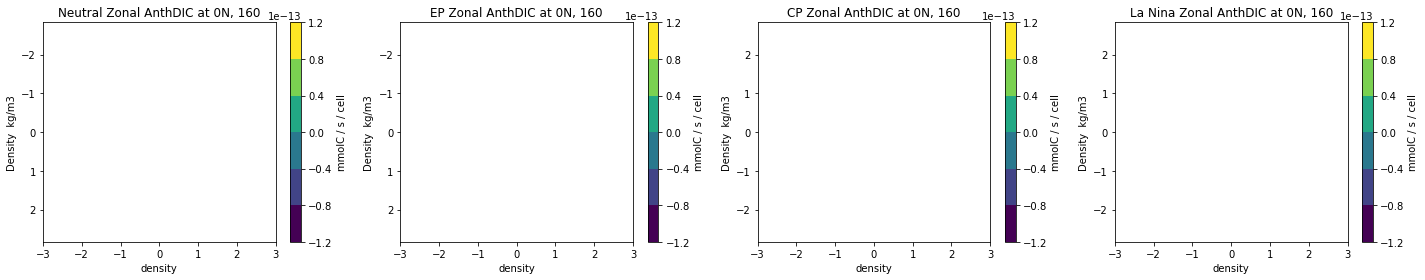

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0. 0.]
nan
[0. 0.]
nan


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


[0. 0.]
nan
[0. 0.]
nan


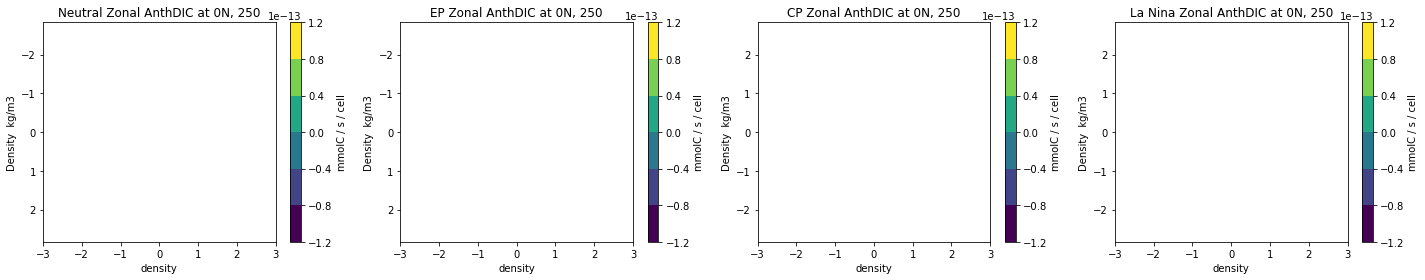

[ 3.0289420e-05 -1.0185059e-05]
87.85869
[ 2.4506791e-05 -1.4171541e-05]
78.02261
[ 3.1359334e-05 -1.3832028e-05]
101.55207
[ 3.323997e-05 -8.692900e-06]
97.922


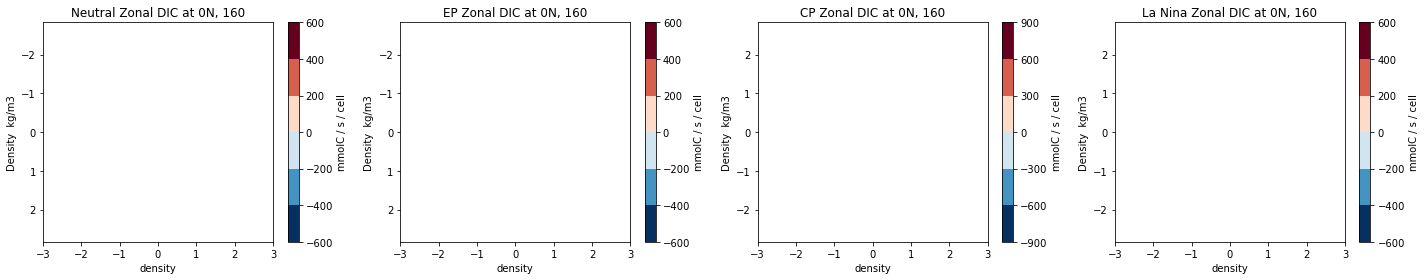

[ 3.0388044e-06 -1.5563268e-05]
29.199953
[ 3.9935412e-06 -1.6687787e-05]
30.94681
[ 3.1740033e-06 -1.6889837e-05]
26.796322
[ 2.2610416e-06 -1.5647300e-05]
27.15801


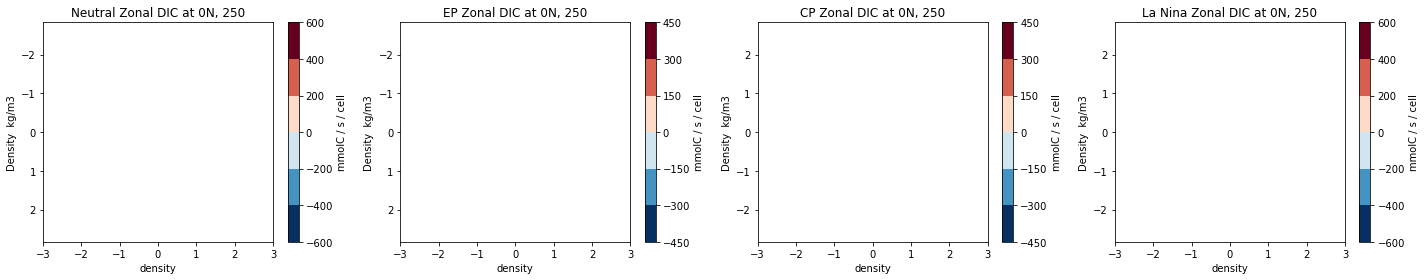

In [31]:
plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx_dens,dic_u_tx_dens]
    
    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):
        
        #ylim=-1000
    
        lons=[160,250]
        for lon in lons:
            if i==0 or i==2:
                levs=None#np.arange(-8e6,8.5e6,5e5)#None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=None#np.arange(-2e8,2.1e8,5e6)#None#np.arange(-1000,1100,100)
                
                
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            
            #lon=180
            lslice=slice(-3,3)

            plt.figure(figsize=(20,4))
            #plt.subplot(251)
            plt.subplot(141)

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(lat=lslice)#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest')#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b.sel(time=neutral_events).mean(dim='time'))

            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            #plt.ylim([ylim,0])
            
            plt.ylabel('Density  kg/m3')
            plt.xlim([-3,3])
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1]) # Reverse Yax.

            plt.subplot(142)
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b.sel(time=ep_events).mean(dim='time'))
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.ylabel('Density  kg/m3')
            plt.xlim([-3,3])
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1]) # Reverse Yax.

            plt.subplot(143)
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b.sel(time=cp_events).mean(dim='time'))
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Density  kg/m3')

            plt.subplot(144)
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b.sel(time=nina_events).mean(dim='time'))
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            #plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Density  kg/m3')


            plt.tight_layout()
            plt.show()
            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{E_W_names[i]} in {lon}',f'{E_W_names[i]} out {lon}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            #temp_holder

In [ ]:
dic_transport_through_box


### Plot 5+6: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling

flux
anthflux


In [ ]:
xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).mean(dim='time').chunk('auto'))

[44.13533864 -0.3206619 ]
57565087.507472605
[45.23184763 -0.46495201]
58792116.715585046
[48.42848408 -0.26419111]
62091911.54811473
[45.2909909 -1.1806917]
63056195.12322251


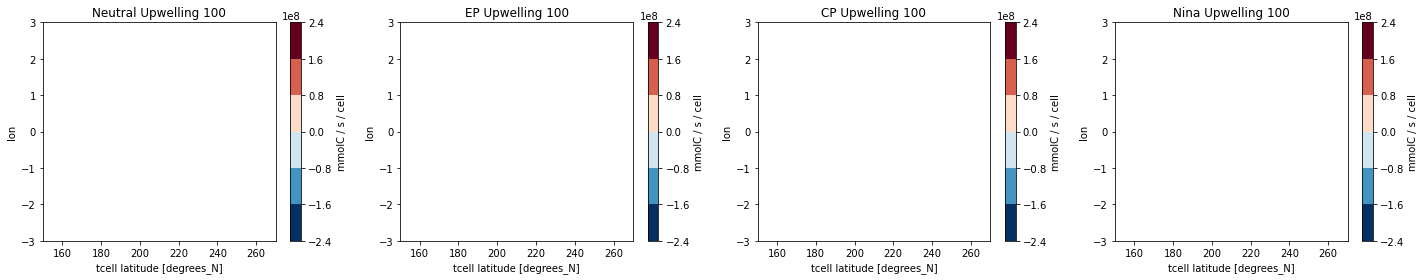

[ 1.09946852 -0.00959256]
1438280.4422188601
[ 1.20404067 -0.01198344]
1551270.8948383583
[ 1.22724586 -0.0087326 ]
1574260.1493245175
[ 1.10838545 -0.03079446]
1534253.192126908


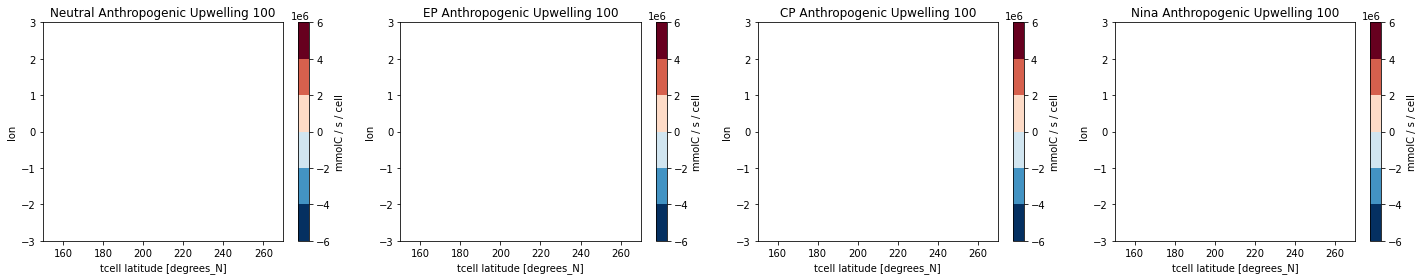

KeyboardInterrupt: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7f7abb22c3a0> (for post_execute):
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/IPython/core/events.py", line 89, in trigger
    func(*args, **kwargs)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 121, in flush_figures
    return show(True)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj

In [ ]:
plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_700.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_700.sel(time=slice('2000-01-01','2020-01-01')),

                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','Anthropogenic Upwelling 100','Upwelling 500','Anthropogenic Upwelling 500','Upwelling 700','Anthropogenic Upwelling 700','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').T.plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).chunk('auto').mean(dim='time'))

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').T.plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat.sel(time=ep_events).chunk('auto').mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').T.plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat.sel(time=cp_events).chunk('auto').mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').T.plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat.sel(time=nina_events).chunk('auto').mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
dic_transport_through_box#=dic_transport_through_box[:-8]

In [ ]:
dic_transport_through_box.to_csv('dic_tx.csv')

## End Box Estimate

In [ ]:
dic_transport_through_box
# in PgC/yr???

In [ ]:
#dic_tx_pgC

In [ ]:
#dic_tx_pgC.iloc[-4:]

In [ ]:
dic_transport_through_box=pd.read_csv('dic_tx.csv',index_col=0).replace(0,np.nan)
# Should have been saved in Petagrams.
#dic_tx_pgC=((dic_transport_through_box)*12*60*60*24*365)/1e9 #
dic_transport_through_box.iloc[-4:]=dic_transport_through_box.iloc[-4:]*-1 # Co2 Flux Directions are wrong way around.

# Units are 1e9 mmoles/s
# Pretty sure this is Petagrams. is 15 and 50PG seem correct for meridional and zonal transport of C / yr? Outgassing is like 1, so probably?
# 12 (molC to gC) * seconds *minutes* hours*days / 1e9 (rather than 1e15 since we are in 1,000,000 kg/yr not g. 
#Rather than 1e15 # Because its already in 1,000,000kg/s ??

#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('100')]
#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('500')]



names=dic_transport_through_box.index

old_tx=dic_transport_through_box[names.str.lower().str.contains('old')]
old_tx_anth=old_tx[old_tx.index.str.lower().str.contains('anth')]
for anth in old_tx_anth.index:
    if anth in old_tx.index:
        old_tx=old_tx.drop(anth)
        
new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)

In [ ]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
new_tx

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling 500','upwelling 700','upwelling 100','flux']
box_faces=['3s','3n','160','250','upwelling 700','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
        
    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    box_res.plot.bar(ax=ax)
    plt.axhline(0,c='k')
    plt.show()
    
    print(box_res)
    #plt.figure(figsize=(12,5))
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth